## Ziele
Festlegung der Zielgroesse: PCR Platte, spezifisch, wird in kontaminierte Platte (Platte 1) und nicht kontaminierte Platte unterschieden. Ziel ist es mit einem ueberwachtem Lernverfahren vorherzusagen, ob eine Platte kontaminiert sein wird.
Falls das mit annehmbarer Accuracy vorherzusagen ist, interessieren mich vor Allem die Features, die wichtig fuer die Vorhersage sind. Daraus erhoffe ich mir herauszufinden welche Variablen fuer die Kontamination verantwortlich sind / waren. Es handelt sich um eine Klassifikationsaufgabe

## Ziele Bullet Points
* What went wrong with the contaminated PCR Plate
* Can we predict the contaminated PCR Plate
* Are there specific contaminations

## Implementation
* Use Random Forest to predict PCR Plate (1 and other)
* Check Accuracy
- Use RF Feature Importance to find factors that contribute to contamination
- Use Shapley Value to find factors that contribute to contamination


In [50]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import shap

import pprint
import statistics

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate 
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score


np.random.seed(0)



%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,4)

pd.options.mode.chained_assignment = None
pp = pprint.PrettyPrinter(indent=4)

In [2]:
# read data
meta_df = pd.read_csv("../data/output/preprocessed_data.csv",  index_col=0)
seq_df = pd.read_csv("../data/output/seqData.csv", index_col = 0)
otu_info = pd.read_csv("../data/output/otu_info.csv")

otu_info_helper = otu_info.rename(index = otu_info.otu)
otu_info_helper = otu_info_helper.transpose()
whole_meta_df = pd.read_csv("../data/output/whole_preprocessed_meta_data", index_col = 0)
whole_meta_df["PCR_plate"].value_counts(dropna=False)


1    93
2    91
3    15
Name: PCR_plate, dtype: int64

## Task 0: Prepare Data specifically for supervised models
I want to classify the count data as well as the metadata based on if the pcr plate was contamined. Therefore, I aggregate the information about the PCR plate of the sample into two groups: contamined (plate 1) and not contamined(plates 2,3). The contamined plates are encoded with a 1, the non-contamined plates with a 0.
Subsequently, I will save the target variable (contamined, not contamined) as an extra vector an remove it from the dataframe we train and test with. I will perform to analyses: The main analysis will use the OTU Counts as features to predict if the plate will be contamined. If the predictions work with sufficient accuracy, I will investigate which OTUs have the highest influence on the prediction. I will perform the same anlayses with the metadata.

In [3]:

# Modify target variable
meta_df = meta_df.assign(
    is_contamined = lambda dataframe: dataframe['PCR_plate'].map(lambda PCR_plate: 1 if PCR_plate == 1 else 0) 
)
meta_df = meta_df.drop(columns=["PCR_plate"])




In [4]:
whole_meta_df = whole_meta_df.assign(
    is_contamined = lambda dataframe: dataframe['PCR_plate'].map(lambda PCR_plate: 1 if PCR_plate == 1 else 0) 
)
whole_meta_df = whole_meta_df.drop(columns=["PCR_plate"])

In [5]:
whole_meta_df.is_contamined.dtypes


dtype('int64')

In [6]:

meta_df.head()
whole_meta_df.head()

,Rearing_LAB,Sex,Age_weeks,Animals_for,cage_ID,BOX,Position,sample_type,extraction_date,extraction_run,...,tail_handling,BW_g,BW1_g,BW2_g,BW3_g,BW4_g,BW5_g,Notes,median_count,is_contamined
100A,LAB_3,F,14.0,behaviour,BF4,3.0,17.0,primary,29/5/2020,15.0,...,no,NaN,19.1,20.5,20.3,21.1,21.8,NaN,0.0,0
100B,LAB_3,F,14.0,gene_expr,BF4,2.0,17.0,primary,14/5/2020,8.0,...,no,NaN,19.2,20.7,21.1,22.2,23.4,NaN,0.0,1
101A,LAB_4,F,14.0,gene_expr,MF7,2.0,23.0,primary,14/5/2020,8.0,...,yes,NaN,17.0,20.1,19.9,19.8,21.1,NaN,0.0,1
101B,LAB_4,F,14.0,behaviour,MF7,3.0,23.0,primary,2/6/2020,16.0,...,yes,NaN,15.5,17.8,18.0,18.5,18.9,NaN,0.0,0
103A,LAB_4,F,14.0,behaviour,MF2,3.0,19.0,primary,2/6/2020,16.0,...,yes,NaN,16.0,18.4,18.3,17.9,19.1,NaN,0.0,0


In [7]:
meta_df.shape

(173, 42)



## Task 1:  split data in test and validation data
Therefore I use a custom function to have balanced classes, as mentioned before my target variable ist if the plate was contaminied

In [8]:
def split_to_train_test(df, label_column, train_frac=0.8):
    train_df, test_df = pd.DataFrame(), pd.DataFrame()
    labels = df[label_column].unique()
    for lbl in labels:
        lbl_df = df[df[label_column] == lbl]
        lbl_train_df = lbl_df.sample(frac=train_frac)
        lbl_test_df = lbl_df.drop(lbl_train_df.index)
        print('\n%s:\n---------\ntotal:%d\ntrain_df:%d\ntest_df:%d' % (lbl, len(lbl_df), len(lbl_train_df), len(lbl_test_df)))
        train_df = train_df.append(lbl_train_df)
        test_df = test_df.append(lbl_test_df)

    return train_df, test_df

In [9]:
whole_meta_df.shape

(199, 61)

In [10]:
meta_df.shape

(173, 42)

In [11]:
train_df_meta, test_df_meta = split_to_train_test(meta_df, "is_contamined",0.7)
seq_df_and_target = seq_df
seq_df_and_target["is_contamined"] = whole_meta_df.is_contamined
train_df_counts, test_df_counts = split_to_train_test(seq_df_and_target, "is_contamined", 0.7)
seq_df_and_target.shape


0:
---------
total:90
train_df:63
test_df:27

1:
---------
total:83
train_df:58
test_df:25

0:
---------
total:106
train_df:74
test_df:32

1:
---------
total:93
train_df:65
test_df:28


(199, 1565)

In [12]:
# Check Class Balance to select suitable evaluation metric
meta_df.is_contamined.value_counts()


0    90
1    83
Name: is_contamined, dtype: int64

## Task 2: Select a evaluation metric
For my first analyses I will chose the Accuracy as defined: Accuracy = (TP+TN)/(TP+FP+FN+TN) as a metric. It is a well established metric for a two class classification problem and since we have equally balanced classes it is a reasonable choice

## Task 3: Create a baseline model
Since I have a two class classification problem with balanced classes, it is suitable to chose the relative frequency of the more frequent class as naive baseline prediction accuracy.


In [13]:
# baseline estimation

freq_class = max(meta_df.is_contamined.value_counts())
baseline = freq_class / len(meta_df.index)
print("Baseline Estimation ${}".format(baseline))

Baseline Estimation $0.5202312138728323


## Task 4: Build a decision tree model
Use a decisoin tree as a very simple supervised method to see if more complex models are justified

In [72]:


# function that returns predictions of a Decision Tree
# takes whole dataframe including the target variable as input
def train_dec_tree(df, target):
    
    # prepare data
    y_train = df.loc[:, target]
    X_train = df.drop(columns=[target])
    
    # Create Decision Tree classifer object
    clf = DecisionTreeClassifier()

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    return clf




In [74]:
scores_prec


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [71]:
print(statistics.mean(scores_prec))
print(statistics.mean(scores_acc))
print(statistics.mean(scores_recall))
print(statistics.mean(scores_f1))

1.0
1.0
1.0
1.0


### Decision Tree for count data

In [15]:
clf_count_data = train_dec_tree(train_df_counts, "is_contamined")
clf_count_data.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [73]:
count_pred = clf_count_data.predict(test_df_counts.drop(columns=["is_contamined"]))
metrics.accuracy_score(test_df_counts.is_contamined, count_pred)
clf_report_dt_count = metrics.classification_report(test_df_counts.is_contamined, count_pred)
pp.pprint(clf_report_dt_count)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.71      0.62      0.67        32\n'
 '           1       0.62      0.71      0.67        28\n'
 '\n'
 '    accuracy                           0.67        60\n'
 '   macro avg       0.67      0.67      0.67        60\n'
 'weighted avg       0.67      0.67      0.67        60\n')


In [17]:
f1_score(test_df_counts.is_contamined, count_pred)

0.6666666666666666

### Decision Tree for meta data

In [18]:
clf_meta_data = train_dec_tree(train_df_meta, "is_contamined")
meta_pred = clf_meta_data.predict(test_df_meta.drop(columns=["is_contamined"]))
metrics.accuracy_score(test_df_meta.is_contamined, meta_pred)
clf_report_dt_meta = metrics.classification_report(test_df_meta.is_contamined, meta_pred)
pp.pprint(clf_report_dt_meta)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       1.00      1.00      1.00        27\n'
 '           1       1.00      1.00      1.00        25\n'
 '\n'
 '    accuracy                           1.00        52\n'
 '   macro avg       1.00      1.00      1.00        52\n'
 'weighted avg       1.00      1.00      1.00        52\n')


## Task 5: Use a supervised machine learning model
I have two objectives: Firstly, I want to find out what is distinctive for samples that were one the contamined plate 1. Therefore I am not so much interested in the prediction itself, rather then the features that are important for the prediction. So for the first question I use a random forest model and extract the feature importance. Additionally, I will use the shapley value to assess feature importance.

Secondly, I am interested if it is possible to predict on which plate the contamination was. Therefore, I use the above-trained Random Forest model and baselines classifiers. Additionally, I will train a Mulit Layer Perceptron and Cross Validation to predict the plate.

In [19]:

# functions that return predictions of a Random Forest
def train_test_rf(df, target):
    
    # prepare data
    y_train = df.loc[:, target]
    X_train = df.drop(columns=[target])
    
    clf = RandomForestClassifier(n_estimators=200)
    clf = clf.fit(X_train, y_train)
  
    return clf

In [77]:
rfc = RandomForestClassifier(n_estimators=200)
scores_prec = cross_val_score(rfc, seq_df, seq_df_and_target.is_contamined, cv = 10, scoring='precision')
scores_acc = cross_val_score(rfc, seq_df, seq_df_and_target.is_contamined, cv = 10, scoring='accuracy')
scores_recall = cross_val_score(rfc, seq_df, seq_df_and_target.is_contamined, cv = 10, scoring='recall')
scores_f1 = cross_val_score(rfc, seq_df, seq_df_and_target.is_contamined, cv = 10, scoring='f1')

In [79]:
print(statistics.mean(scores_prec),statistics.stdev(scores_prec))
print(statistics.mean(scores_acc))
print(statistics.mean(scores_recall))
print(statistics.mean(scores_f1))

0.9344444444444444 0.11903245053276604
0.8239473684210527
0.6711111111111111
0.7729326332422307


In [20]:
# prints accuracy and displays confusion table as heatmap
def accurcay_confusion_heatmap(test_df, predictions, target):
    conf_mat = confusion_matrix(test_df.loc[:,target], predictions)
    print(conf_mat)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(test_df.loc[:,target], predictions))
    # helper df for heatmap
    df_cm = pd.DataFrame(conf_mat, range(2), range(2))
    # plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 4}) # font size

    plt.show()

### Supervised model for count data

In [21]:
count_rf_clf = train_test_rf(train_df_counts, "is_contamined")
count_pred_rf = count_rf_clf.predict(test_df_counts.drop(columns=["is_contamined"]))

rf_default_values = count_rf_clf.get_params()
rf_default_values

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [22]:
clf_report_count = metrics.classification_report(test_df_counts.is_contamined, count_pred_rf)
pp.pprint(clf_report_count)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.83      0.94      0.88        32\n'
 '           1       0.92      0.79      0.85        28\n'
 '\n'
 '    accuracy                           0.87        60\n'
 '   macro avg       0.88      0.86      0.86        60\n'
 'weighted avg       0.87      0.87      0.87        60\n')


[[30  2]
 [ 6 22]]
Accuracy: 0.8666666666666667


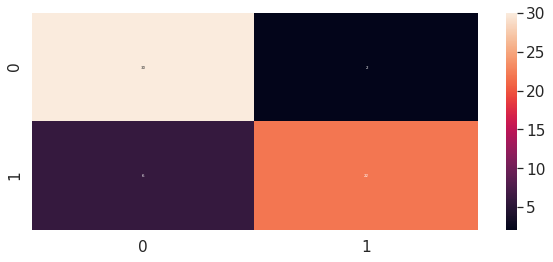

In [23]:
accurcay_confusion_heatmap(test_df_counts, count_pred_rf, "is_contamined")

### Supervised model for meta data

In [24]:
meta_rf_clf = train_test_rf(train_df_meta, "is_contamined")
meta_pred_rf = meta_rf_clf.predict(test_df_meta.drop(columns=["is_contamined"]))
metrics.accuracy_score(test_df_meta.is_contamined, meta_pred_rf)
clf_report_rf_meta = metrics.classification_report(test_df_meta.is_contamined, meta_pred_rf)
pp.pprint(clf_report_rf_meta)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       1.00      1.00      1.00        27\n'
 '           1       1.00      1.00      1.00        25\n'
 '\n'
 '    accuracy                           1.00        52\n'
 '   macro avg       1.00      1.00      1.00        52\n'
 'weighted avg       1.00      1.00      1.00        52\n')



## Task 5.1

To get a insight what was differnt on the contamined plates, respectively which features contributet to the contamination, I now investigate the feature importance of the RF.

In [25]:
def plt_feat_importance(clf, target_var, features):
    
    feat_importances = pd.Series(clf.feature_importances_, index=features)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.xlabel("Mean Decrease Impurity", fontsize = 18)

    return feat_importances

In [26]:
otu_info_helper.head()

,otu1,otu2,otu3,otu4,otu5,otu6,otu7,otu8,otu9,otu10,...,otu1555,otu1556,otu1557,otu1558,otu1559,otu1560,otu1561,otu1562,otu1563,otu1564
Unnamed: 0,0,1,2,3,4,5,6,7,8,9,...,1554,1555,1556,1557,1558,1559,1560,1561,1562,1563
otu,otu1,otu2,otu3,otu4,otu5,otu6,otu7,otu8,otu9,otu10,...,otu1555,otu1556,otu1557,otu1558,otu1559,otu1560,otu1561,otu1562,otu1563,otu1564
seq,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTG...,TACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGCG...,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTG...,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCT...,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTG...,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTG...,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTG...,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,...,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,CGTCGGCAGCGTCAGATGTGTATAAGAGACAGTGCAGGTGCCAGCA...,TACGGAGGATGCGAGCGTTATCCGGATTTACTGGGTGTAAAGGGGG...,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGGG...,TACGTAGGGGGCAAGCGTTATCCGGATTCACTGGGCGTAAAGGGAG...,TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGGGTG...,TACGGAGGATCCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTG...,TACGGAGGATTCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGTGTAAAGGGAG...,TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAG...
tax,rootrank;Root;62.12|domain;Bacteria;62.12|phyl...,rootrank;Root;100|domain;Bacteria;100|phylum;F...,rootrank;Root;72.8|domain;Bacteria;72.8|phylum...,rootrank;Root;98.27|domain;Bacteria;98.27|phyl...,rootrank;Root;100|domain;Bacteria;100|phylum;F...,rootrank;Root;57.53|domain;Bacteria;57.53|phyl...,rootrank;Root;64.9|domain;Bacteria;64.44|phylu...,rootrank;Root;66.29|domain;Bacteria;66.29|phyl...,rootrank;Root;67.98|domain;Bacteria;67.98|phyl...,rootrank;Root;100|domain;Bacteria;100|phylum;F...,...,rootrank;Root;62.98|domain;Bacteria;62.98|phyl...,rootrank;Root;48.03|domain;Bacteria;45.85|phyl...,rootrank;Root;68.61|domain;Bacteria;68.61|phyl...,rootrank;Root;75.6|domain;Bacteria;75.6|phylum...,rootrank;Root;83.43|domain;Bacteria;83.43|phyl...,rootrank;Root;58.62|domain;Bacteria;58.62|phyl...,rootrank;Root;60.66|domain;Bacteria;60.66|phyl...,rootrank;Root;64.48|domain;Bacteria;64.48|phyl...,rootrank;Root;68.38|domain;Bacteria;68.38|phyl...,rootrank;Root;74.04|domain;Bacteria;74.04|phyl...


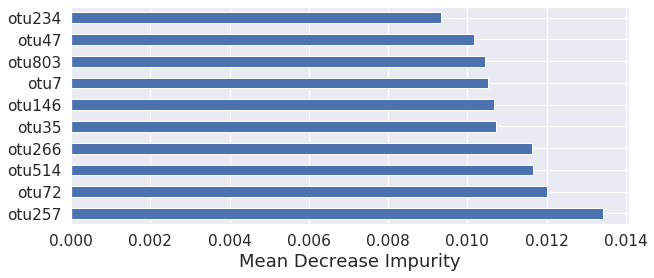

In [27]:
# plot feature importance for count data
importance = plt_feat_importance(count_rf_clf, "is_contamined", otu_info_helper.columns)


otu1       0.001795
otu2       0.000645
otu3       0.002293
otu4       0.000273
otu5       0.001648
             ...   
otu1560    0.000000
otu1561    0.000000
otu1562    0.000000
otu1563    0.000000
otu1564    0.000000
Length: 1564, dtype: float64

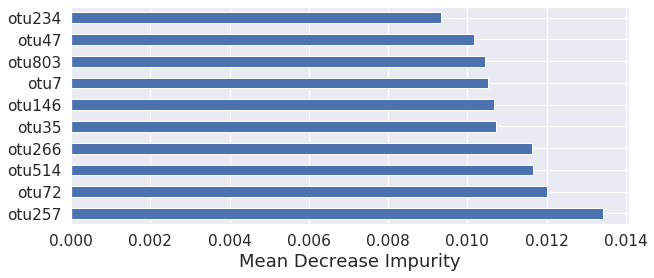

In [28]:
 plt_feat_importance(count_rf_clf, "is_contamined", otu_info_helper.columns)

In [29]:


meta_df.columns

Index(['Rearing_LAB ', 'Age_weeks', 'sample_type', 'extraction_date',
       'extraction_run', 'extracted_by', 'DNA_elution_Vol_ul',
       'Quantification_method', 'DNA_conc_ng_ul', '260 / 280', '230 / 260',
       '16S_PCR_date', 'PCR_row', 'PCR_position', 'library_conc_ng_ul',
       'FA_kit_used', 'repeat_library_prep', 'library_prep_attempt',
       'Use_for_pooling', 'Dilution_factor', 'Vol_EB_ul', 'Vol_DNA_ul',
       'light_cycle', 'cage_type', 'bedding_material', 'bedding_autoclaved',
       'house_present', 'roll_present', 'enrichment_autoclaved', 'diet',
       'diet_treatment', 'water_autoclaved', 'water_chlorinated',
       'mean_room_temp_C', 'room_humidity', 'other_animals_present',
       'other_animals_present_kind', 'housing_room_condition', 'tail_handling',
       'Notes', 'median_count', 'is_contamined'],
      dtype='object')

Rearing_LAB                   0.001002
Age_weeks                     0.042199
sample_type                   0.000000
extraction_date               0.024910
extraction_run                0.191823
extracted_by                  0.003018
DNA_elution_Vol_ul            0.028419
Quantification_method         0.039261
DNA_conc_ng_ul                0.006448
260 / 280                     0.011789
230 / 260                     0.003637
16S_PCR_date                  0.240368
PCR_row                       0.006543
PCR_position                  0.003541
library_conc_ng_ul            0.014808
FA_kit_used                   0.134554
repeat_library_prep           0.000000
library_prep_attempt          0.205869
Use_for_pooling               0.000000
Dilution_factor               0.020761
Vol_EB_ul                     0.007793
Vol_DNA_ul                    0.000000
light_cycle                   0.000098
cage_type                     0.001770
bedding_material              0.000205
bedding_autoclaved       

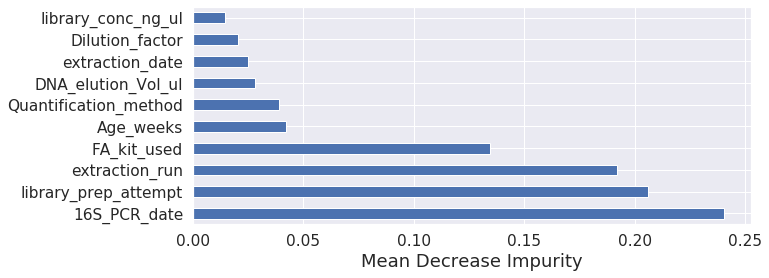

In [30]:
# plot feature importance for meta data
plt_feat_importance(meta_rf_clf, "is_contamined", meta_df.drop(columns=["is_contamined"]).columns)

## Shapley Value for feature contribution
// TODO describe


In [52]:

def plot_shap_val(clf, X_train):
    
    shap_obj  = shap.TreeExplainer(clf)
    shap_values = shap_obj.shap_values(X_train)
    shap.summary_plot(shap_values, X_train)
    return shap_obj

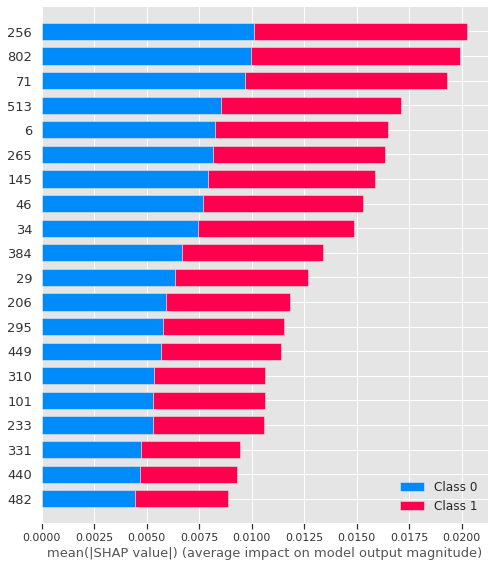

In [53]:
# get shapley values for count data and plot
count_shap_vals = plot_shap_val(count_rf_clf, train_df_counts)



In [54]:
count_shap_vals.get_params()

AttributeError: 'Tree' object has no attribute 'get_params'

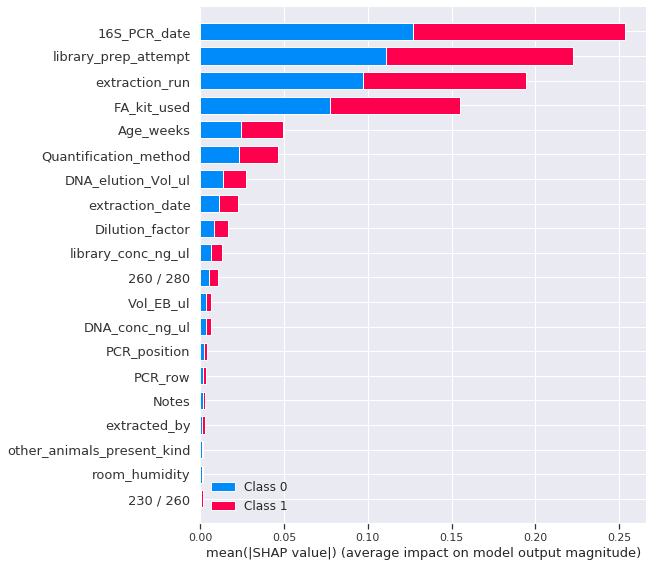

In [33]:
# geth shapley values and plot for meta data
count_meta_vals = plot_shap_val(meta_rf_clf, train_df_meta)

## Task 5.2 Multi Layer Perceptron
Before I train the model, I need to scale the data (this was not necessary for the Random Forest, because it can deal with unscaled data). I did this during preprocessing and only need to load the data

In [34]:
scaled_df = pd.read_csv("../data/output/scaled_seq.csv")


In [35]:
scaled_df.shape

(199, 1565)

In [36]:
meta_df.shape

(173, 42)

In [37]:
model = MLPClassifier() 
is_contamined = whole_meta_df.is_contamined
is_contamined.index = range(len(is_contamined))
scaled_df.index = range(len(scaled_df))
scaled_df = scaled_df.drop(scaled_df.columns[0], axis=1)

# cv_results = cross_validate(model,scaled_df, is_contamined, cv=10, 
#                             return_train_score=False, 
#                             scoring=model.score) 
# print("Fit scores: {}".format(cv_results['test_score']))

from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
clf = MLPClassifier()
score_list = []
report_list = []
for train_indices, test_indices in kf.split(scaled_df):
    clf.fit(scaled_df.iloc[train_indices,:], is_contamined[train_indices])
    pred = clf.predict(scaled_df.iloc[test_indices,:])
    print(pred)
    cur_report = metrics.classification_report(pred, is_contamined[test_indices])
    cur_score = clf.score(scaled_df.iloc[test_indices,:], is_contamined[test_indices])
    score_list.append(cur_score)
    report_list.append(cur_report)
    pp.pprint(cur_report)
    print(cur_score)

[1 1 0 0 1 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0]
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.70      0.58      0.64        12\n'
 '           1       0.50      0.62      0.56         8\n'
 '\n'
 '    accuracy                           0.60        20\n'
 '   macro avg       0.60      0.60      0.60        20\n'
 'weighted avg       0.62      0.60      0.60        20\n')
0.6
[0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 0]
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.65      1.00      0.79        13\n'
 '           1       0.00      0.00      0.00         7\n'
 '\n'
 '    accuracy                           0.65        20\n'
 '   macro avg       0.33      0.50      0.39        20\n'
 'weighted avg       0.42      0.65      0.51        20\n')
0.65


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.90      1.00      0.95        18\n'
 '           1       0.00      0.00      0.00         2\n'
 '\n'
 '    accuracy                           0.90        20\n'
 '   macro avg       0.45      0.50      0.47        20\n'
 'weighted avg       0.81      0.90      0.85        20\n')
0.9


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


[0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1]
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.88      0.93      0.90        15\n'
 '           1       0.75      0.60      0.67         5\n'
 '\n'
 '    accuracy                           0.85        20\n'
 '   macro avg       0.81      0.77      0.78        20\n'
 'weighted avg       0.84      0.85      0.84        20\n')
0.85
[1 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0]
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.75      0.69      0.72        13\n'
 '           1       0.50      0.57      0.53         7\n'
 '\n'
 '    accuracy                           0.65        20\n'
 '   macro avg       0.62      0.63      0.63        20\n'
 'weighted avg       0.66      0.65      0.65        20\n')
0.65
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0]
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.91      0.56      0.69        18\n'
 '    

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.00      0.00      0.00         0\n'
 '           1       1.00      0.95      0.97        20\n'
 '\n'
 '    accuracy                           0.95        20\n'
 '   macro avg       0.50      0.47      0.49        20\n'
 'weighted avg       1.00      0.95      0.97        20\n')
0.95


Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


[1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 1 0]
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.00      0.00      0.00         7\n'
 '           1       0.63      0.92      0.75        13\n'
 '\n'
 '    accuracy                           0.60        20\n'
 '   macro avg       0.32      0.46      0.37        20\n'
 'weighted avg       0.41      0.60      0.49        20\n')
0.6
[0 1 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0]
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.00      0.00      0.00         8\n'
 '           1       0.58      1.00      0.73        11\n'
 '\n'
 '    accuracy                           0.58        19\n'
 '   macro avg       0.29      0.50      0.37        19\n'
 'weighted avg       0.34      0.58      0.42        19\n')
0.5789473684210527


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [38]:
statistics.median(score_list)
1+1+0.94+0.94+0.25+0/29+0.5+0.3+0

4.93

In [39]:
statistics.mean(score_list)

0.6578947368421053

In [40]:
clf.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

## Result Analyse
I will create boxplots of the most important and least important otus

In [41]:
most_important = importance.nlargest(10)
most_important_names = list(most_important.index)
most_important_ind = [int(x[3:]) for x in most_important_names]
most_important_ind

[257, 72, 514, 266, 35, 146, 7, 803, 47, 234]

In [42]:
least_important = importance.nsmallest(10)
least_important

otu61     0.0
otu225    0.0
otu272    0.0
otu281    0.0
otu340    0.0
otu357    0.0
otu390    0.0
otu396    0.0
otu401    0.0
otu403    0.0
dtype: float64

In [43]:
least_important_names = list(least_important.index)
least_important_ind = [int(x[3:]) for x in least_important_names]
least_important_ind

[61, 225, 272, 281, 340, 357, 390, 396, 401, 403]

In [44]:
seq_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1555,1556,1557,1558,1559,1560,1561,1562,1563,is_contamined
100A,121182,0,9921,1351,65360,24331,3858,15493,373,1911,...,0,0,0,0,0,0,0,0,0,0
100B,51332,0,5047,97217,245,5078,1564,8653,2739,2879,...,0,0,0,0,0,0,0,0,0,1
101A,47276,250,27034,917,32350,11503,6836,26665,9471,286,...,0,0,0,0,0,0,0,0,0,1
101B,35653,0,25285,145,41464,16648,4978,20689,8220,281,...,0,0,0,0,0,0,0,0,0,0
103A,90972,962,1765,93,188,16078,12066,20746,15073,38305,...,0,0,0,0,0,0,0,0,0,0


In [45]:
least_important_df = seq_df.iloc[:,least_important_ind]
most_important_df = seq_df.iloc[:,most_important_ind]

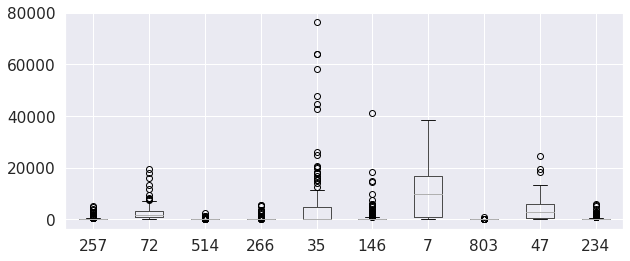

In [46]:
most_important_df.boxplot()

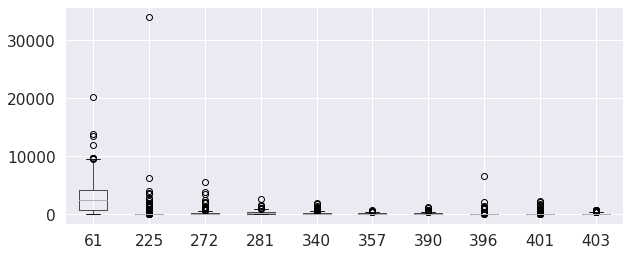

In [47]:
least_important_df.boxplot()

20.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
77.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
81.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
80.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
88.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
86.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
87.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
84.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
85.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


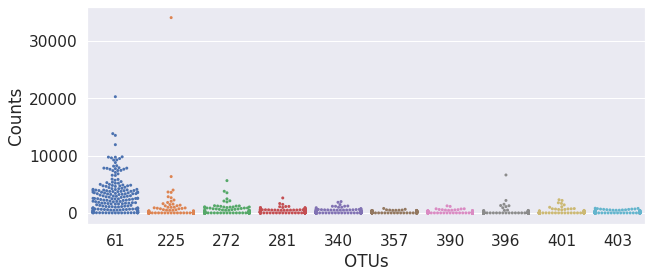

In [48]:
sns.swarmplot(x = "OTUs", y = "Counts",data = pd.melt(least_important_df,
                                            var_name="OTUs", value_name="Counts"), s = 3)


In [49]:
sns.swarmplot(x = "OTUs", y = "Counts",data = pd.melt(most_important_df.iloc[,,
                                            var_name="OTUs", value_name="Counts"), s = 3)


SyntaxError: invalid syntax (<ipython-input-49-7cc9d0e611e5>, line 1)

In [ ]:
sns.swarmplot(x = "OTUs", y = "Counts",data = pd.melt(seq_df,
                                            var_name="OTUs", value_name="Counts"), s = 3)

In [ ]:
seq_df.head()


In [ ]:
k = "otu104"

In [ ]:
k[len(k)-3::]

In [ ]:
seq_df.shape